In [2]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ROOT

from root_pandas import read_root, to_root

from xgboost import XGBClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

from uncertainties import ufloat

In [3]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

In [4]:
bdt_df = read_root('./data/bdt-selection-run1.root')

In [5]:
classic_df = read_root('./data/classic-selection-run1.root')

In [6]:
for df in [bdt_df, classic_df]:
    df['event_id'] = df.runNumber.apply(str) + '_' + df.eventNumber.apply(str)

In [7]:
bdt_same = bdt_df[bdt_df.event_id.isin(classic_df.event_id)]

In [8]:
num_same = ufloat((bdt_same.__array_index == classic_df.__array_index).sum(), np.sqrt(len(classic_df)))
num_total = ufloat(len(classic_df), np.sqrt(len(classic_df)))

In [9]:
print(100 * num_same / num_total)

98.6+/-0.5


## How different is Run1 vs Run2 data?

In [10]:
bdt_run2 = read_root('./data/bdt-selection-run2.root')

In [11]:
bdt_df['run'] = 1
bdt_run2['run'] = 2

In [12]:
# equal number of events from both sets
indices = np.arange(len(bdt_df))
np.random.shuffle(indices)

In [13]:
bdt_df = bdt_df.iloc[indices[:len(bdt_run2)]]

In [14]:
df = pd.concat([bdt_df, bdt_run2])

In [15]:
# this is the list of BDT variables formerly used
MVA_features = [
    'tp_partP',
    'tp_partPt',
    'tp_IPPU',
    'tp_ghostProb',
    'tp_PIDNNm',
    'tp_ABS_RecVertexIP',
    'tp_mult',
    'tp_ptB',
    'tp_IPs',
    'tp_partlcs',
    'tp_PROBNNpi',
    'tp_PROBNNk',
    'tp_PROBNNp',
    'tp_PROBNNe',
]

In [16]:
train_df, test_df = train_test_split(df, test_size=0.5)

In [17]:
model = XGBClassifier(max_depth=5, n_estimators=300, nthread=12)

In [18]:
model.fit(train_df[MVA_features], train_df.run)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=300, nthread=12,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [19]:
probas = model.predict_proba(test_df[MVA_features])
probas_train = model.predict_proba(train_df[MVA_features])

In [20]:
test_score = roc_auc_score(test_df.run == 2, probas[:, 1])

In [21]:
fpr, tpr, _ = roc_curve(test_df.run == 2, probas[:, 1])
fpr_train, tpr_train, _ = roc_curve(train_df.run == 2, probas_train[:, 1])

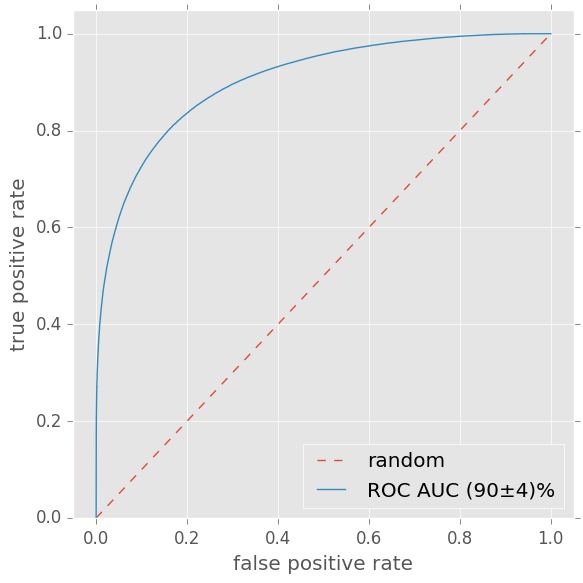

In [37]:
plt.figure(figsize=(6, 6))
plt.plot([0, 1], '--', label='random')
plt.plot(fpr, tpr, label=u'ROC AUC (90±4)%'.format(100 * test_score))
# plt.plot(fpr_train, tpr_train, label='ROC curve (train)', alpha=0.5)
plt.xlim(-0.05, 1.05)
plt.ylim(0, 1.05)
plt.legend(loc='best')
plt.xlabel(r'false positive rate')
plt.ylabel(r'true positive rate')
plt.tight_layout()
plt.savefig('./build/roc_curve_run1_run2.pdf', bbox_inches='tight')
plt.show()

In [23]:
score = cross_val_score(model, df[MVA_features], df.run == 1, scoring='roc_auc', n_jobs=1, cv=30, verbose=1)

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 21.7min finished


In [29]:
print(100 * ufloat(score.mean(), score.std()))

90+/-4
